# What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.


# Table of Contents

This notebook has 5 parts. We will walk through TensorFlow at three different levels of abstraction, which should help you better understand it and prepare you for working on your project.

1. Preparation: load the CIFAR-10 dataset.
2. Barebone TensorFlow: we will work directly with low-level TensorFlow graphs. 
3. Keras Model API: we will use `tf.keras.Model` to define arbitrary neural network architecture. 
4. Keras Sequential API: we will use `tf.keras.Sequential` to define a linear feed-forward network very conveniently. 
5. CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `tf.keras.Model`     | High        | Medium      |
| `tf.keras.Sequential` | Low         | High        |

# Part I: Preparation

First, we load the CIFAR-10 dataset. This might take a few minutes to download the first time you run it, but after that the files should be cached on disk and loading should be faster.

In previous parts of the assignment we used CS231N-specific code to download and read the CIFAR-10 dataset; however the `tf.keras.datasets` package in TensorFlow provides prebuilt utility functions for loading many common datasets.

For the purposes of this assignment we will still write our own code to preprocess the data and iterate through it in minibatches. The `tf.data` package in TensorFlow provides tools for automating this process, but working with this package adds extra complication and is beyond the scope of this notebook. However using `tf.data` can be much more efficient than the simple approach used in this notebook, so you should consider using it for your project.

In [0]:
from time import time
import os, math, timeit
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [102]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Preparation: Dataset object

For our own convenience we'll define a lightweight `Dataset` class which lets us iterate over data and labels. This is not the most flexible or most efficient way to iterate through data, but it will serve our purposes.

In [0]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
            self.X, self.y = self.X[idxs], self.y[idxs]
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


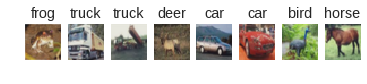

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(inps, clss, title=None):
    """Imshow for Tensor."""
    mean = np.array([0.4914, 0.4822, 0.4465])[None,None,None,:]
    std = np.array([0.2023, 0.1994, 0.2010])[None,None,None,:]
    inps = std * inps + mean
    inps = np.clip(inps, 0, 1)
    for i in range(8):
      plt.subplot(1,8,i+1)
      plt.imshow(inps[i])
      plt.axis('off')
      plt.title(classes[clss[i]])

dset = Dataset(X_train, y_train, batch_size=8, shuffle=True)
inps, clss = next(iter(dset))

imshow(inps, clss)

You can optionally **use GPU by setting the flag to True below**. It's not neccessary to use a GPU for this assignment; if you are working on Google Cloud then we recommend that you do not use a GPU, as it will be significantly more expensive.

In [4]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Part II: Barebone TensorFlow
TensorFlow ships with various high-level APIs which make it very convenient to define and train neural networks; we will cover some of these constructs in Part III and Part IV of this notebook. In this section we will start by building a model with basic TensorFlow constructs to help you better understand what's going on under the hood of the higher-level APIs.

TensorFlow is primarily a framework for working with **static computational graphs**. Nodes in the computational graph are Tensors which will hold n-dimensional arrays when the graph is run; edges in the graph represent functions that will operate on Tensors when the graph is run to actually perform useful computation.

This means that a typical TensorFlow program is written in two distinct phases:

1. Build a computational graph that describes the computation that you want to perform. This stage doesn't actually perform any computation; it just builds up a symbolic representation of your computation. This stage will typically define one or more `placeholder` objects that represent inputs to the computational graph.
2. Run the computational graph many times. Each time the graph is run you will specify which parts of the graph you want to compute, and pass a `feed_dict` dictionary that will give concrete values to any `placeholder`s in the graph.

### TensorFlow warmup: Flatten Function

We can see this in action by defining a simple `flatten` function that will reshape image data for use in a fully-connected network.

In TensorFlow, data for convolutional feature maps is typically stored in a Tensor of shape N x H x W x C where:

- N is the number of datapoints (minibatch size)
- H is the height of the feature map
- W is the width of the feature map
- C is the number of channels in the feature map

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `H x W x C` values per representation into a single long vector. The flatten function below first reads in the value of N from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be H x W x C, but we don't need to specify that explicitly). 

**NOTE**: TensorFlow and PyTorch differ on the default Tensor layout; TensorFlow uses N x H x W x C but PyTorch uses N x C x H x W.

In [0]:
def flatten(x):
    """    
    Input:
    - TensorFlow Tensor of shape (N, D1, ..., DM)
    
    Output:
    - TensorFlow Tensor of shape (N, D1 * ... * DM)
    """
    N = tf.shape(x)[0]
    return tf.reshape(x, (N, -1))

In [7]:
def test_flatten():
    # Clear the current TensorFlow graph.
    tf.reset_default_graph()
    
    # Stage I: Define the TensorFlow graph describing our computation.
    # In this case the computation is trivial: we just want to flatten
    # a Tensor using the flatten function defined above.
    
    # Our computation will have a single input, x. We don't know its
    # value yet, so we define a placeholder which will hold the value
    # when the graph is run. We then pass this placeholder Tensor to
    # the flatten function; this gives us a new Tensor which will hold
    # a flattened view of x when the graph is run. The tf.device
    # context manager tells TensorFlow whether to place these Tensors
    # on CPU or GPU.
    with tf.device(device):
        x = tf.placeholder(tf.float32)
        x_flat = flatten(x)
    
    # At this point we have just built the graph describing our computation,
    # but we haven't actually computed anything yet. If we print x and x_flat
    # we see that they don't hold any data; they are just TensorFlow Tensors
    # representing values that will be computed when the graph is run.
    print('x: ', type(x), x)
    print('x_flat: ', type(x_flat), x_flat)
    print()
    
    # We need to use a TensorFlow Session object to actually run the graph.
    with tf.Session() as sess:
        # Construct concrete values of the input data x using numpy
        x_np = np.arange(24).reshape((2, 3, 4))
        print('x_np:\n', x_np, '\n')
    
        # Run our computational graph to compute a concrete output value.
        # The first argument to sess.run tells TensorFlow which Tensor
        # we want it to compute the value of; the feed_dict specifies
        # values to plug into all placeholder nodes in the graph. The
        # resulting value of x_flat is returned from sess.run as a
        # numpy array.
        x_flat_np = sess.run(x_flat, feed_dict={x: x_np})
        print('x_flat_np:\n', x_flat_np, '\n')

        # We can reuse the same graph to perform the same computation
        # with different input data
        x_np = np.arange(12).reshape((2, 3, 2))
        print('x_np:\n', x_np, '\n')
        x_flat_np = sess.run(x_flat, feed_dict={x: x_np})
        print('x_flat_np:\n', x_flat_np)
test_flatten()

x:  <class 'tensorflow.python.framework.ops.Tensor'> Tensor("Placeholder:0", dtype=float32, device=/device:GPU:0)
x_flat:  <class 'tensorflow.python.framework.ops.Tensor'> Tensor("Reshape:0", shape=(?, ?), dtype=float32, device=/device:GPU:0)

x_np:
 [[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]] 

x_flat_np:
 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.]] 

x_np:
 [[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]] 

x_flat_np:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]]


### Barebones TensorFlow: Two-Layer Network
We will now implement our first neural network with TensorFlow: a fully-connected ReLU network with two hidden layers and no biases on the CIFAR10 dataset. For now we will use only low-level TensorFlow operators to define the network; later we will see how to use the higher-level abstractions provided by `tf.keras` to simplify the process.

We will define the forward pass of the network in the function `two_layer_fc`; this will accept TensorFlow Tensors for the inputs and weights of the network, and return a TensorFlow Tensor for the scores. It's important to keep in mind that calling the `two_layer_fc` function **does not** perform any computation; instead it just sets up the computational graph for the forward computation. To actually run the network we need to enter a TensorFlow Session and feed data to the computational graph.

After defining the network architecture in the `two_layer_fc` function, we will test the implementation by setting up and running a computational graph, feeding zeros to the network and checking the shape of the output.

It's important that you read and understand this implementation.

In [0]:
def two_layer_fc(x, params):
    """
    A fully-connected neural network; the architecture is:
    fully-connected layer -> ReLU -> fully connected layer.
    Note that we only need to define the forward pass here; TensorFlow will take
    care of computing the gradients for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A TensorFlow Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of TensorFlow Tensors giving weights for the
      network, where w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A TensorFlow Tensor of shape (N, C) giving classification scores
      for the input data x.
    """
    w1, w2 = params  # Unpack the parameters
    x = flatten(x)   # Flatten the input; now x has shape (N, D)
    h = tf.nn.relu(tf.matmul(x, w1)) # Hidden layer: h has shape (N, H)
    scores = tf.matmul(h, w2)        # Compute scores of shape (N, C)
    return scores

In [14]:
def two_layer_fc_test():
    # TensorFlow's default computational graph is essentially a hidden global
    # variable. To avoid adding to this default graph when you rerun this cell,
    # we clear the default graph before constructing the graph we care about.
    tf.reset_default_graph()
    hidden_layer_size = 42

    # Scoping our computational graph setup code under a tf.device context
    # manager lets us tell TensorFlow where we want these Tensors to be
    # placed.
    with tf.device(device):
        # Set up a placehoder for the input of the network, and constant
        # zero Tensors for the network weights. Here we declare w1 and w2
        # using tf.zeros instead of tf.placeholder as we've seen before - this
        # means that the values of w1 and w2 will be stored in the computational
        # graph itself and will persist across multiple runs of the graph; in
        # particular this means that we don't have to pass values for w1 and w2
        # using a feed_dict when we eventually run the graph.
        x = tf.placeholder(tf.float32)
        w1 = tf.zeros((32 * 32 * 3, hidden_layer_size))
        w2 = tf.zeros((hidden_layer_size, 10))
        
        # Call our two_layer_fc function to set up the computational
        # graph for the forward pass of the network.
        scores = two_layer_fc(x, [w1, w2])
    
    # Use numpy to create some concrete data that we will pass to the
    # computational graph for the x placeholder.
    x_np = np.zeros((64, 32, 32, 3))
    with tf.Session() as sess:
        # The calls to tf.zeros above do not actually instantiate the values
        # for w1 and w2; the following line tells TensorFlow to instantiate
        # the values of all Tensors (like w1 and w2) that live in the graph.
        sess.run(tf.global_variables_initializer())
        
        # Here we actually run the graph, using the feed_dict to pass the
        # value to bind to the placeholder for x; we ask TensorFlow to compute
        # the value of the scores Tensor, which it returns as a numpy array.
        scores_np = sess.run(scores, feed_dict={x: x_np})
        print(scores_np.shape)

two_layer_fc_test()

(64, 10)


### Barebones TensorFlow: Three-Layer ConvNet
Here you will complete the implementation of the function `three_layer_convnet` which will perform the forward pass of a three-layer convolutional network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for `C` classes.

**HINT**: For convolutions: https://www.tensorflow.org/api_docs/python/tf/nn/conv2d; be careful with padding!

**HINT**: For biases: https://www.tensorflow.org/performance/xla/broadcasting

In [0]:
def three_layer_convnet(x, params):
    """
    A three-layer convolutional network with the architecture described above.
    
    Inputs:
    - x: A TensorFlow Tensor of shape (N, H, W, 3) giving a minibatch of images
    - params: A list of TensorFlow Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: TensorFlow Tensor of shape (KH1, KW1, 3, channel_1) giving
        weights for the first convolutional layer.
      - conv_b1: TensorFlow Tensor of shape (channel_1,) giving biases for the
        first convolutional layer.
      - conv_w2: TensorFlow Tensor of shape (KH2, KW2, channel_1, channel_2)
        giving weights for the second convolutional layer
      - conv_b2: TensorFlow Tensor of shape (channel_2,) giving biases for the
        second convolutional layer.
      - fc_w: TensorFlow Tensor giving weights for the fully-connected layer.
        Can you figure out what the shape should be?
      - fc_b: TensorFlow Tensor giving biases for the fully-connected layer.
        Can you figure out what the shape should be?
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.            #
    ############################################################################
    x = tf.nn.conv2d(x, conv_w1, [1,1,1,1], padding='SAME') + conv_b1
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(x, conv_w2, [1,1,1,1], padding='SAME') + conv_b2
    x = tf.nn.relu(x)
    x = flatten(x)
    scores = tf.matmul(x, fc_w) + fc_b
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################
    return scores

After defing the forward pass of the three-layer ConvNet above, run the following cell to test your implementation. Like the two-layer network, we use the `three_layer_convnet` function to set up the computational graph, then run the graph on a batch of zeros just to make sure the function doesn't crash, and produces outputs of the correct shape.

When you run this function, `scores_np` should have shape `(64, 10)`.

In [18]:
def three_layer_convnet_test():
    tf.reset_default_graph()

    with tf.device(device):
        x = tf.placeholder(tf.float32)
        conv_w1 = tf.zeros((5, 5, 3, 6))
        conv_b1 = tf.zeros((6,))
        conv_w2 = tf.zeros((3, 3, 6, 9))
        conv_b2 = tf.zeros((9,))
        fc_w = tf.zeros((32 * 32 * 9, 10))
        fc_b = tf.zeros((10,))
        params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
        scores = three_layer_convnet(x, params)

    # Inputs to convolutional layers are 4-dimensional arrays with shape
    # [batch_size, height, width, channels]
    x_np = np.zeros((64, 32, 32, 3))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores, feed_dict={x: x_np})
        print('scores_np has shape: ', scores_np.shape)

with tf.device('/cpu:0'):
    three_layer_convnet_test()

scores_np has shape:  (64, 10)


### Barebones TensorFlow: Training Step
We now define the `training_step` function which sets up the part of the computational graph that performs a single training step. This will take three basic steps:

1. Compute the loss
2. Compute the gradient of the loss with respect to all network weights
3. Make a weight update step using (stochastic) gradient descent.

Note that the step of updating the weights is itself an operation in the computational graph - the calls to `tf.assign_sub` in `training_step` return TensorFlow operations that mutate the weights when they are executed. There is an important bit of subtlety here - when we call `sess.run`, TensorFlow does not execute all operations in the computational graph; it only executes the minimal subset of the graph necessary to compute the outputs that we ask TensorFlow to produce. As a result, naively computing the loss would not cause the weight update operations to execute, since the operations needed to compute the loss do not depend on the output of the weight update. To fix this problem, we insert a **control dependency** into the graph, adding a duplicate `loss` node to the graph that does depend on the outputs of the weight update operations; this is the object that we actually return from the `training_step` function. As a result, asking TensorFlow to evaluate the value of the `loss` returned from `training_step` will also implicitly update the weights of the network using that minibatch of data.

We need to use a few new TensorFlow functions to do all of this:
- For computing the cross-entropy loss we'll use `tf.nn.sparse_softmax_cross_entropy_with_logits`: https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits
- For averaging the loss across a minibatch of data we'll use `tf.reduce_mean`:
https://www.tensorflow.org/api_docs/python/tf/reduce_mean
- For computing gradients of the loss with respect to the weights we'll use `tf.gradients`:  https://www.tensorflow.org/api_docs/python/tf/gradients
- We'll mutate the weight values stored in a TensorFlow Tensor using `tf.assign_sub`: https://www.tensorflow.org/api_docs/python/tf/assign_sub
- We'll add a control dependency to the graph using `tf.control_dependencies`: https://www.tensorflow.org/api_docs/python/tf/control_dependencies

In [0]:
def training_step(scores, y, params, learning_rate):
    """
    Set up the part of the computational graph which makes a training step.

    Inputs:
    - scores: TensorFlow Tensor of shape (N, C) giving classification scores for
      the model.
    - y: TensorFlow Tensor of shape (N,) giving ground-truth labels for scores;
      y[i] == c means that c is the correct class for scores[i].
    - params: List of TensorFlow Tensors giving the weights of the model
    - learning_rate: Python scalar giving the learning rate to use for gradient
      descent step.
      
    Returns:
    - loss: A TensorFlow Tensor of shape () (scalar) giving the loss for this
      batch of data; evaluating the loss also performs a gradient descent step
      on params (see above).
    """
    # First compute the loss; the first line gives losses for each example in
    # the minibatch, and the second averages the losses acros the batch
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss = tf.reduce_mean(losses)

    # Compute the gradient of the loss with respect to each parameter of the the
    # network. This is a very magical function call: TensorFlow internally
    # traverses the computational graph starting at loss backward to each element
    # of params, and uses backpropagation to figure out how to compute gradients;
    # it then adds new operations to the computational graph which compute the
    # requested gradients, and returns a list of TensorFlow Tensors that will
    # contain the requested gradients when evaluated.
    grad_params = tf.gradients(loss, params)
    
    # Make a gradient descent step on all of the model parameters.
    new_weights = []   
    for w, grad_w in zip(params, grad_params):
        new_w = tf.assign_sub(w, learning_rate * grad_w)
        new_weights.append(new_w)

    # Insert a control dependency so that evaluting the loss causes a weight
    # update to happen; see the discussion above.
    with tf.control_dependencies(new_weights):
        return tf.identity(loss)

### Barebones TensorFlow: Training Loop
Now we set up a basic training loop using low-level TensorFlow operations. We will train the model using stochastic gradient descent without momentum. The `training_step` function sets up the part of the computational graph that performs the training step, and the function `train_part2` iterates through the training data, making training steps on each minibatch, and periodically evaluates accuracy on the validation set.

In [0]:
def train_part2(model_fn, init_fn, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    # First clear the default graph
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    # Set up the computational graph for performing forward and backward passes,
    # and weight updates.
    with tf.device(device):
        # Set up placeholders for the data and labels
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        params = init_fn()           # Initialize the model parameters
        scores = model_fn(x, params) # Forward pass of the model
        loss = training_step(scores, y, params, learning_rate)

    # Now we actually run the graph many times using the training data
    with tf.Session() as sess:
        # Initialize variables that will live in the graph
        sess.run(tf.global_variables_initializer())
        for t, (x_np, y_np) in enumerate(train_dset):
            # Run the graph on a batch of training data; recall that asking
            # TensorFlow to evaluate loss will cause an SGD step to happen.
            feed_dict = {x: x_np, y: y_np}
            loss_np = sess.run(loss, feed_dict=feed_dict)
            
            # Periodically print the loss and check accuracy on the val set
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss_np))
                check_accuracy(sess, val_dset, x, scores, is_training)

### Barebones TensorFlow: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets. Note that this function accepts a TensorFlow Session object as one of its arguments; this is needed since the function must actually run the computational graph many times on the data that it loads from the dataset `dset`.

Also note that we reuse the same computational graph both for taking training steps and for evaluating the model; however since the `check_accuracy` function never evalutes the `loss` value in the computational graph, the part of the graph that updates the weights of the graph do not execute on the validation data.

In [0]:
def check_accuracy(sess, dset, x, scores, is_training=None):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### Barebones TensorFlow: Initialization
We'll use the following utility method to initialize the weight matrices for our models using Kaiming's normalization method.

[1] He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [0]:
def kaiming_normal(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.random_normal(shape) * np.sqrt(2.0 / fan_in)

### Barebones TensorFlow: Train a Two-Layer Network
We are finally ready to use all of the pieces defined above to train a two-layer fully-connected network on CIFAR-10.

We just need to define a function to initialize the weights of the model, and call `train_part2`.

Defining the weights of the network introduces another important piece of TensorFlow API: `tf.Variable`. A TensorFlow Variable is a Tensor whose value is stored in the graph and persists across runs of the computational graph; however unlike constants defined with `tf.zeros` or `tf.random_normal`, the values of a Variable can be mutated as the graph runs; these mutations will persist across graph runs. Learnable parameters of the network are usually stored in Variables.

You don't need to tune any hyperparameters, but you should achieve accuracies above 40% after one epoch of training.

In [13]:
def two_layer_fc_init():
    """
    Initialize the weights of a two-layer network, for use with the
    two_layer_network function defined above.
    
    Inputs: None
    
    Returns: A list of:
    - w1: TensorFlow Variable giving the weights for the first layer
    - w2: TensorFlow Variable giving the weights for the second layer
    """
    hidden_layer_size = 4000
    w1 = tf.Variable(kaiming_normal((3 * 32 * 32, 4000)))
    w2 = tf.Variable(kaiming_normal((4000, 10)))
    return [w1, w2]

learning_rate = 1e-2
train_part2(two_layer_fc, two_layer_fc_init, learning_rate)

Iteration 0, loss = 2.9196
Got 118 / 1000 correct (11.80%)
Iteration 100, loss = 2.0021
Got 376 / 1000 correct (37.60%)
Iteration 200, loss = 1.3809
Got 382 / 1000 correct (38.20%)
Iteration 300, loss = 1.8982
Got 358 / 1000 correct (35.80%)
Iteration 400, loss = 1.6026
Got 407 / 1000 correct (40.70%)
Iteration 500, loss = 1.7458
Got 428 / 1000 correct (42.80%)
Iteration 600, loss = 1.8089
Got 423 / 1000 correct (42.30%)
Iteration 700, loss = 1.9884
Got 439 / 1000 correct (43.90%)


### Barebones TensorFlow: Train a three-layer ConvNet
We will now use TensorFlow to train a three-layer ConvNet on CIFAR-10.

You need to implement the `three_layer_convnet_init` function. Recall that the architecture of the network is:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't need to do any hyperparameter tuning, but you should see accuracies above 43% after one epoch of training.

In [14]:
def three_layer_convnet_init():
    """
    Initialize the weights of a Three-Layer ConvNet, for use with the
    three_layer_convnet function defined above.
    
    Inputs: None
    
    Returns a list containing:
    - conv_w1: TensorFlow Variable giving weights for the first conv layer
    - conv_b1: TensorFlow Variable giving biases for the first conv layer
    - conv_w2: TensorFlow Variable giving weights for the second conv layer
    - conv_b2: TensorFlow Variable giving biases for the second conv layer
    - fc_w: TensorFlow Variable giving weights for the fully-connected layer
    - fc_b: TensorFlow Variable giving biases for the fully-connected layer
    """
    params = None
    ############################################################################
    # TODO: Initialize the parameters of the three-layer network.              #
    ############################################################################
    conv_w1 = tf.Variable(kaiming_normal((5, 5, 3, 32)))
    conv_b1 = tf.Variable(tf.zeros((32, )))
    conv_w2 = tf.Variable(kaiming_normal((3, 3, 32, 16)))
    conv_b2 = tf.Variable(tf.zeros((16, )))
    fc_w = tf.Variable(kaiming_normal((16 * 32 * 32, 10)))
    fc_b = tf.Variable(tf.zeros((10, )))
    params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return params

learning_rate = 3e-3
train_part2(three_layer_convnet, three_layer_convnet_init, learning_rate)

Iteration 0, loss = 2.6164
Got 97 / 1000 correct (9.70%)
Iteration 100, loss = 1.7870
Got 361 / 1000 correct (36.10%)
Iteration 200, loss = 1.7417
Got 390 / 1000 correct (39.00%)
Iteration 300, loss = 1.7003
Got 397 / 1000 correct (39.70%)
Iteration 400, loss = 1.6670
Got 424 / 1000 correct (42.40%)
Iteration 500, loss = 1.6961
Got 446 / 1000 correct (44.60%)
Iteration 600, loss = 1.5841
Got 475 / 1000 correct (47.50%)
Iteration 700, loss = 1.5814
Got 450 / 1000 correct (45.00%)


# Part III: Keras Model API
Implementing a neural network using the low-level TensorFlow API is a good way to understand how TensorFlow works, but it's a little inconvenient - we had to manually keep track of all Tensors holding learnable parameters, and we had to use a control dependency to implement the gradient descent update step. This was fine for a small network, but could quickly become unweildy for a large complex model.

Fortunately TensorFlow provides higher-level packages such as `tf.keras` and `tf.layers` which make it easy to build models out of modular, object-oriented layers; `tf.train` allows you to easily train these models using a variety of different optimization algorithms.

In this part of the notebook we will define neural network models using the `tf.keras.Model` API. To implement your own model, you need to do the following:

1. Define a new class which subclasses `tf.keras.model`. Give your class an intuitive name that describes it, like `TwoLayerFC` or `ThreeLayerConvNet`.
2. In the initializer `__init__()` for your new class, define all the layers you need as class attributes. The `tf.layers` package provides many common neural-network layers, like `tf.layers.Dense` for fully-connected layers and `tf.layers.Conv2D` for convolutional layers. Under the hood, these layers will construct `Variable` Tensors for any learnable parameters. **Warning**: Don't forget to call `super().__init__()` as the first line in your initializer!
3. Implement the `call()` method for your class; this implements the forward pass of your model, and defines the *connectivity* of your network. Layers defined in `__init__()` implement `__call__()` so they can be used as function objects that transform input Tensors into output Tensors. Don't define any new layers in `call()`; any layers you want to use in the forward pass should be defined in `__init__()`.

After you define your `tf.keras.Model` subclass, you can instantiate it and use it like the model functions from Part II.

### Keras Model API: Two-Layer Network

Here is a concrete example of using the `tf.keras.Model` API to define a two-layer network. There are a few new bits of API to be aware of here:

We use an `Initializer` object to set up the initial values of the learnable parameters of the layers; in particular `tf.variance_scaling_initializer` gives behavior similar to the Kaiming initialization method we used in Part II. You can read more about it here: https://www.tensorflow.org/api_docs/python/tf/variance_scaling_initializer

We construct `tf.layers.Dense` objects to represent the two fully-connected layers of the model. In addition to multiplying their input by a weight matrix and adding a bias vector, these layer can also apply a nonlinearity for you. For the first layer we specify a ReLU activation function by passing `activation=tf.nn.relu` to the constructor; the second layer does not apply any activation function.

Unfortunately the `flatten` function we defined in Part II is not compatible with the `tf.keras.Model` API; fortunately we can use `tf.layers.flatten` to perform the same operation. The issue with our `flatten` function from Part II has to do with static vs dynamic shapes for Tensors, which is beyond the scope of this notebook; you can read more about the distinction [in the documentation](https://www.tensorflow.org/programmers_guide/faq#tensor_shapes).

In [15]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super().__init__()        
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.fc1 = tf.layers.Dense(hidden_size, activation=tf.nn.relu,
                                   kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer)
    def call(self, x, training=None):
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    tf.reset_default_graph()
    input_size, hidden_size, num_classes = 50, 42, 10

    # As usual in TensorFlow, we first need to define our computational graph.
    # To this end we first construct a TwoLayerFC object, then use it to construct
    # the scores Tensor.
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        x = tf.zeros((64, input_size))
        scores = model(x)

    # Now that our computational graph has been defined we can run the graph
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)
        
test_TwoLayerFC()

(64, 10)


###  Funtional API: Two-Layer Network
The `tf.layers` package provides two different higher-level APIs for defining neural network models. In the example above we used the **object-oriented API**, where each layer of the neural network is represented as a Python object (like `tf.layers.Dense`). Here we showcase the **functional API**, where each layer is a Python function (like `tf.layers.dense`) which inputs and outputs TensorFlow Tensors, and which internally sets up Tensors in the computational graph to hold any learnable weights.

To construct a network, one needs to pass the input tensor to the first layer, and construct the subsequent layers sequentially. Here's an example of how to construct the same two-layer nework with the functional API.

In [16]:
def two_layer_fc_functional(inputs, hidden_size, num_classes):     
    initializer = tf.variance_scaling_initializer(scale=2.0)
    flattened_inputs = tf.layers.flatten(inputs)
    fc1_output = tf.layers.dense(flattened_inputs, hidden_size, activation=tf.nn.relu,
                                 kernel_initializer=initializer)
    scores = tf.layers.dense(fc1_output, num_classes,
                             kernel_initializer=initializer)
    return scores

def test_two_layer_fc_functional():
    """ A small unit test to exercise the TwoLayerFC model above. """
    tf.reset_default_graph()
    input_size, hidden_size, num_classes = 50, 42, 10

    # As usual in TensorFlow, we first need to define our computational graph.
    # To this end we first construct a two layer network graph by calling the
    # two_layer_network() function. This function constructs the computation
    # graph and outputs the score tensor.
    with tf.device(device):
        x = tf.zeros((64, input_size))
        scores = two_layer_fc_functional(x, hidden_size, num_classes)

    # Now that our computational graph has been defined we can run the graph
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)
        
test_two_layer_fc_functional()

(64, 10)


### Keras Model API: Three-Layer ConvNet
Now it's your turn to implement a three-layer ConvNet using the `tf.keras.Model` API. Your model should have the same architecture used in Part II:

1. Convolutional layer with 5 x 5 kernels, with zero-padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 3 x 3 kernels, with zero-padding of 1
4. ReLU nonlinearity
5. Fully-connected layer to give class scores

You should initialize the weights of your network using the same initialization method as was used in the two-layer network above.

**Hint**: Refer to the documentation for `tf.layers.Conv2D` and `tf.layers.Dense`:

https://www.tensorflow.org/api_docs/python/tf/layers/Conv2D

https://www.tensorflow.org/api_docs/python/tf/layers/Dense

In [0]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Implement the __init__ method for a three-layer ConvNet. You   #
        # should instantiate layer objects to be used in the forward pass.     #
        ########################################################################
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.conv1 = tf.layers.Conv2D(channel_1, kernel_size=5, padding='same',
                                      activation=tf.nn.relu, kernel_initializer=initializer)
        self.conv2 = tf.layers.Conv2D(channel_2, kernel_size=3, padding='same',
                                      activation=tf.nn.relu, kernel_initializer=initializer)
        self.fc = tf.layers.Dense(num_classes, kernel_initializer=initializer)
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################
        
    def call(self, x, training=None):
        scores = None
        ########################################################################
        # TODO: Implement the forward pass for a three-layer ConvNet. You      #
        # should use the layer objects defined in the __init__ method.         #
        ########################################################################
        x = self.conv1(x)
        x = self.conv2(x)
        x = tf.layers.flatten(x)
        scores = self.fc(x)
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################        
        return scores

Once you complete the implementation of the `ThreeLayerConvNet` above you can run the following to ensure that your implementation does not crash and produces outputs of the expected shape.

In [18]:
def test_ThreeLayerConvNet():
    tf.reset_default_graph()
    
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)

test_ThreeLayerConvNet()

(64, 10)


### Keras Model API: Training Loop
We need to implement a slightly different training loop when using the `tf.keras.Model` API. Instead of computing gradients and updating the weights of the model manually, we use an `Optimizer` object from the `tf.train` package which takes care of these details for us. You can read more about `Optimizer`s here: https://www.tensorflow.org/api_docs/python/tf/train/Optimizer

In [0]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                    print()
                t += 1

### Keras Model API: Train a Two-Layer Network
We can now use the tools defined above to train a two-layer network on CIFAR-10. We define the `model_init_fn` and `optimizer_init_fn` that construct the model and optimizer respectively when called. Here we want to train the model using stochastic gradient descent with no momentum, so we construct a `tf.train.GradientDescentOptimizer` function; you can [read about it here](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer).

You don't need to tune any hyperparameters here, but you should achieve accuracies above 40% after one epoch of training.

In [20]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    return TwoLayerFC(hidden_size, num_classes)(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.6339
Got 131 / 1000 correct (13.10%)

Iteration 100, loss = 1.8126
Got 377 / 1000 correct (37.70%)

Iteration 200, loss = 1.4044
Got 394 / 1000 correct (39.40%)

Iteration 300, loss = 1.7685
Got 387 / 1000 correct (38.70%)

Iteration 400, loss = 1.7865
Got 426 / 1000 correct (42.60%)

Iteration 500, loss = 1.7271
Got 432 / 1000 correct (43.20%)

Iteration 600, loss = 1.9048
Got 433 / 1000 correct (43.30%)

Iteration 700, loss = 1.8010
Got 459 / 1000 correct (45.90%)



### Keras Model API: Train a Two-Layer Network (functional API)
Similarly, we train the two-layer network constructed using the functional API.

In [21]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    return two_layer_fc_functional(inputs, hidden_size, num_classes)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.9557
Got 122 / 1000 correct (12.20%)

Iteration 100, loss = 1.7805
Got 375 / 1000 correct (37.50%)

Iteration 200, loss = 1.4269
Got 403 / 1000 correct (40.30%)

Iteration 300, loss = 1.7834
Got 386 / 1000 correct (38.60%)

Iteration 400, loss = 1.7767
Got 427 / 1000 correct (42.70%)

Iteration 500, loss = 1.7705
Got 444 / 1000 correct (44.40%)

Iteration 600, loss = 1.8961
Got 439 / 1000 correct (43.90%)

Iteration 700, loss = 1.8114
Got 449 / 1000 correct (44.90%)



### Keras Model API: Train a Three-Layer ConvNet
Here you should use the tools we've defined above to train a three-layer ConvNet on CIFAR-10. Your ConvNet should use 32 filters in the first convolutional layer and 16 filters in the second layer.

To train the model you should use gradient descent with Nesterov momentum 0.9. 

**HINT**: https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer

You don't need to perform any hyperparameter tuning, but you should achieve accuracies above 45% after training for one epoch.

In [22]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return model(inputs)

def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9,
                                           use_nesterov=True)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.5795
Got 133 / 1000 correct (13.30%)

Iteration 100, loss = 1.6698
Got 421 / 1000 correct (42.10%)

Iteration 200, loss = 1.3154
Got 480 / 1000 correct (48.00%)

Iteration 300, loss = 1.3704
Got 495 / 1000 correct (49.50%)

Iteration 400, loss = 1.2851
Got 501 / 1000 correct (50.10%)

Iteration 500, loss = 1.4069
Got 546 / 1000 correct (54.60%)

Iteration 600, loss = 1.4024
Got 539 / 1000 correct (53.90%)

Iteration 700, loss = 1.2866
Got 559 / 1000 correct (55.90%)



# Part IV: Keras Sequential API
In Part III we introduced the `tf.keras.Model` API, which allows you to define models with any number of learnable layers and with arbitrary connectivity between layers.

However for many models you don't need such flexibility - a lot of models can be expressed as a sequential stack of layers, with the output of each layer fed to the next layer as input. If your model fits this pattern, then there is an even easier way to define your model: using `tf.keras.Sequential`. You don't need to write any custom classes; you simply call the `tf.keras.Sequential` constructor with a list containing a sequence of layer objects.

One complication with `tf.keras.Sequential` is that you must define the shape of the input to the model by passing a value to the `input_shape` of the first layer in your model.

### Keras Sequential API: Two-Layer Network
Here we rewrite the two-layer fully-connected network using `tf.keras.Sequential`, and train it using the training loop defined above.

You don't need to perform any hyperparameter tuning here, but you should see accuracies above 40% after training for one epoch.

In [23]:
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.8906
Got 140 / 1000 correct (14.00%)

Iteration 100, loss = 1.7652
Got 392 / 1000 correct (39.20%)

Iteration 200, loss = 1.4289
Got 415 / 1000 correct (41.50%)

Iteration 300, loss = 1.7614
Got 388 / 1000 correct (38.80%)

Iteration 400, loss = 1.7348
Got 431 / 1000 correct (43.10%)

Iteration 500, loss = 1.8028
Got 440 / 1000 correct (44.00%)

Iteration 600, loss = 1.7838
Got 433 / 1000 correct (43.30%)

Iteration 700, loss = 1.8298
Got 455 / 1000 correct (45.50%)



### Keras Sequential API: Three-Layer ConvNet
Here you should use `tf.keras.Sequential` to reimplement the same three-layer ConvNet architecture used in Part II and Part III. As a reminder, your model should have the following architecture:

1. Convolutional layer with 16 5x5 kernels, using zero padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 32 3x3 kernels, using zero padding of 1
4. ReLU nonlinearity
5. Fully-connected layer giving class scores

You should initialize the weights of the model using a `tf.variance_scaling_initializer` as above.

You should train the model using Nesterov momentum 0.9.

You don't need to perform any hyperparameter search, but you should achieve accuracy above 45% after training for one epoch.

In [27]:
def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [tf.layers.Conv2D(16, kernel_size=5, padding='same',
                               activation=tf.nn.relu, kernel_initializer=initializer),
              tf.layers.Conv2D(32, kernel_size=3, padding='same',
                               activation=tf.nn.relu, kernel_initializer=initializer),
              tf.layers.Flatten(),
              tf.layers.Dense(10, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model(inputs)

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9,
                                           use_nesterov=True)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.6368
Got 75 / 1000 correct (7.50%)

Iteration 100, loss = 1.7685
Got 409 / 1000 correct (40.90%)

Iteration 200, loss = 1.4849
Got 448 / 1000 correct (44.80%)

Iteration 300, loss = 1.5942
Got 480 / 1000 correct (48.00%)

Iteration 400, loss = 1.4373
Got 486 / 1000 correct (48.60%)

Iteration 500, loss = 1.5882
Got 521 / 1000 correct (52.10%)

Iteration 600, loss = 1.5195
Got 517 / 1000 correct (51.70%)

Iteration 700, loss = 1.4477
Got 513 / 1000 correct (51.30%)



# Part V: CIFAR-10 open-ended challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the `check_accuracy` and `train` functions from above, or you can implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### WARNING: Batch Normalization / Dropout
Batch Normalization and Dropout **WILL NOT WORK CORRECTLY** if you use the `train_part34()` function with the object-oriented `tf.keras.Model` or `tf.keras.Sequential` APIs; if you want to use these layers with this training loop then you **must use the tf.layers functional API**.

We wrote `train_part34()` to explicitly demonstrate how TensorFlow works; however there are some subtleties that make it tough to handle the object-oriented batch normalization layer in a simple training loop. In practice both `tf.keras` and `tf` provide higher-level APIs which handle the training loop for you, such as [keras.fit](https://keras.io/models/sequential/) and [tf.Estimator](https://www.tensorflow.org/programmers_guide/estimators), both of which will properly handle batch normalization when using the object-oriented API.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training! 

In [0]:
def foward_pass(sess, x_batch, y_batch, x, y, scores, loss, is_training):
    feed_dict = {x: x_batch, y: y_batch, is_training: 0}
    scores_np, loss_np = sess.run([scores, loss], feed_dict=feed_dict)
    y_pred = scores_np.argmax(axis=1)
    num_samples = x_batch.shape[0]
    num_correct = (y_pred == y_batch).sum()
    return num_correct, num_samples, loss_np


def check_accuracy(sess, dset, x, y, scores, loss, is_training):
    num_correct, num_samples, losses = 0, 0, []
    for x_batch, y_batch in dset:
        n_correct, n_samples, l_np = foward_pass(sess, x_batch, y_batch, x, y,
                                                 scores, loss, is_training)
        num_samples += n_samples
        num_correct += n_correct
        losses.append(l_np)
    acc = float(num_correct) / num_samples
    loss_np = np.mean(losses)
    print('Got loss %.4f, %d / %d correct (%.2f%%)' % (loss_np, num_correct, num_samples, 100 * acc))
    return acc, loss_np


def net_solver(model_init_fn, optimizer_init_fn, num_epochs=1, pre_load=False, is_testing=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for epochs on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train:
          model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
          optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    - pre_load: Whether to pre-load trained model or not
    - is_testing: Whether to evaluate the test set or not. When set to True,
      the pre_load should also be set to True
    
    Returns: Nothing, but prints progress during trainingn
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
    
    # Add an op to initialize the variables.
    init_op = tf.global_variables_initializer()
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        if pre_load:
            saver.restore(sess, "./best_model.ckpt")
            if is_testing:
                print('Checking accuracy on test set')
                te_acc, te_loss = check_accuracy(sess, test_dset, x, y, 
                                                 scores, loss, is_training)
                return
        else:
            sess.run(init_op)
        
        # Log the initial performance
        x_bch, y_bch = next(iter(train_dset))
        n_correct, n_samples, bch_loss = foward_pass(sess, x_bch, y_bch, x, y,
                                                     scores, loss, is_training)
        val_acc, val_loss = check_accuracy(sess, val_dset, x, y, 
                                           scores, loss, is_training)
        loss_history, val_loss_history = [bch_loss], [val_loss]
        train_acc_history, val_acc_history = [float(n_correct) / n_samples], [val_acc]
        best_val_acc = val_acc
        
        # Start training for epochs
        for epoch in range(num_epochs):
            print('\nEpoch %d / %d:' % (epoch + 1, num_epochs))
            t = 0
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                scores_np, loss_np, _ = sess.run([scores, loss, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                t += 1
            
            # Checkpoint and record/print metrics at epoch end
            y_pred = scores_np.argmax(axis=1)
            bch_acc = float((y_pred == y_np).sum()) / x_np.shape[0]
            bch_loss = loss_np
            print('Batch loss %.4f, acc %.2f' % (bch_loss, 100 * bch_acc))
            print('Checking accuracy on validation set')
            val_acc, val_loss = check_accuracy(sess, val_dset, x, y, 
                                               scores, loss, is_training)
            loss_history.append(bch_loss)
            val_loss_history.append(val_loss)
            train_acc_history.append(bch_acc)
            val_acc_history.append(val_acc)
            
            if val_acc > best_val_acc:
                print('Saving model...')
                best_val_acc = val_acc
                save_path = saver.save(sess, "./best_model.ckpt")
            print()
            
    return [train_acc_history, val_acc_history, loss_history, val_loss_history]


# Visualize training log
def plot_history(history):
    # plot history of loss and acc
    accs, val_accs, losses, val_losses = history
    epochs = range(len(accs))
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, accs, '-o')
    ax1.plot(epochs, val_accs, '-o')
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'val'], loc='lower right')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, losses, '-o')
    ax2.plot(epochs, val_losses, '-o')
    ax2.set_ylim(bottom=-0.1)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'val'], loc='upper right')

Got loss 2.9829, 111 / 1000 correct (11.10%)

Epoch 1 / 15:
Iteration 0, loss = 3.9243
Iteration 100, loss = 2.0886
Iteration 200, loss = 1.7364
Iteration 300, loss = 2.1482
Iteration 400, loss = 1.8453
Iteration 500, loss = 2.1628
Iteration 600, loss = 1.9096
Iteration 700, loss = 1.8342
Batch loss 1.9796, acc 25.00
Checking accuracy on validation set
Got loss 1.5619, 433 / 1000 correct (43.30%)
Saving model...


Epoch 2 / 15:
Iteration 0, loss = 1.7465
Iteration 100, loss = 1.7274
Iteration 200, loss = 1.6568
Iteration 300, loss = 1.7452
Iteration 400, loss = 1.6140
Iteration 500, loss = 1.6860
Iteration 600, loss = 1.4310
Iteration 700, loss = 1.6918
Batch loss 1.6942, acc 30.00
Checking accuracy on validation set
Got loss 1.2918, 553 / 1000 correct (55.30%)
Saving model...


Epoch 3 / 15:
Iteration 0, loss = 1.7465
Iteration 100, loss = 1.5441
Iteration 200, loss = 1.3936
Iteration 300, loss = 1.6702
Iteration 400, loss = 1.4884
Iteration 500, loss = 1.5212
Iteration 600, loss = 1.

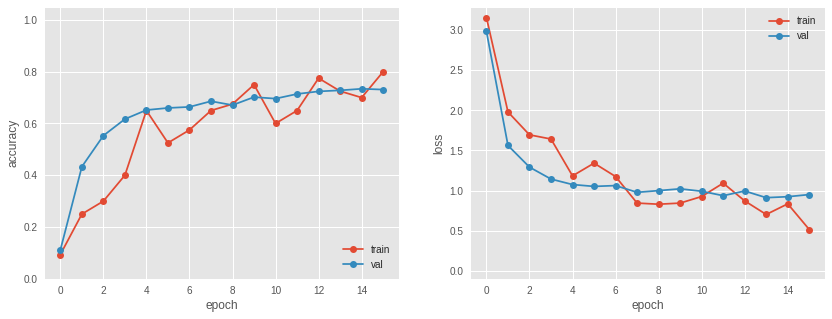

In [12]:
learning_rate = 1e-3

def model_init_fn(inputs, is_training):
    initializer = tf.variance_scaling_initializer(scale=2.0)
    x = tf.layers.conv2d(inputs, 64, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.conv2d(x, 64, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2))
    x = tf.layers.conv2d(inputs, 128, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.conv2d(x, 128, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2))
    x = tf.layers.conv2d(inputs, 256, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.conv2d(x, 256, kernel_size=3, padding='same',
                         activation=tf.nn.relu, kernel_initializer=initializer)
    x = tf.layers.batch_normalization(x, training=is_training)
    x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2))
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, 512, kernel_initializer=initializer, activation=tf.nn.relu)
    x = tf.layers.dropout(x, 0.5, training=is_training)
    scores = tf.layers.dense(x, 10, kernel_initializer=initializer)
    return scores


def optimizer_init_fn():
    return tf.train.AdamOptimizer(learning_rate)


t0 = time()
history = net_solver(model_init_fn, optimizer_init_fn, num_epochs=15)
plot_history(history)
print('Training goes with %.2f seconds.' %(time()-t0))

In [13]:
net_solver(model_init_fn, optimizer_init_fn, pre_load=True, is_testing=True)

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Checking accuracy on test set
Got loss 0.9720, 7026 / 10000 correct (70.26%)


## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Tell us what you did